In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
import os
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Sun Oct  2 07:33:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Todo: Testset accuracy at highest val-acc and at end for all good settings
from google.colab import drive
import sys
import os
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Look if there is overlap between testset and train_val_set (very slight overlap detected, but nothing skewing results much)
if False:
    for (i,_) in test_dataset:
      min_dist = 100000
      for (j,_) in train_val_dataset:
        if torch.norm(i-j, p=2) < min_dist:
          min_dist = torch.norm(i-j, p=2)
      print(min_dist)

In [5]:
BATCH_SIZE=64

dir_path_train = '/content/gdrive/MyDrive/makeathon/tomato/train'
dir_path_test = '/content/gdrive/MyDrive/makeathon/tomato/val'

augment = torchvision.transforms.Compose([
    transforms.Resize(size=(128, 128)), 
    transforms.ToTensor()
])

train_val_dataset = datasets.ImageFolder(root=dir_path_train, transform=augment)
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [9000, 1000])
test_dataset = datasets.ImageFolder(root=dir_path_test, transform=augment)

# Set dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True, num_workers=4)

train_set_size, val_set_size, test_set_size = len(train_dataset), len(val_dataset), len(test_dataset)
print('Train size:', train_set_size, "\nVal size:", val_set_size, '\nTest size:', test_set_size)

Train size: 9000 
Val size: 1000 
Test size: 1000


Image_show torch.Size([128, 128, 3])
Image shape: torch.Size([3, 128, 128])
Num of classes: 10


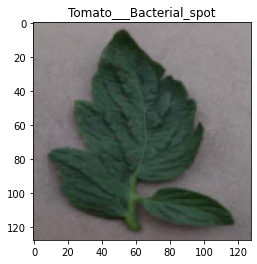

In [6]:
classes = train_val_dataset.classes

img, label = train_val_dataset[0]
img_sample = img.permute(1, 2, 0) 

print("Image_show", img_sample.shape)
print('Image shape:', img.shape)
print('Num of classes:', len(classes))
plt.imshow(img_sample)
plt.title(classes[label]);

In [ ]:
model = torchvision.models.efficientnet_b0(weights="EfficientNet_B0_Weights.IMAGENET1K_V1")
model.classifier[1] = torch.nn.Linear(in_features=1280, out_features=10, bias=True)
for param in model.parameters():
    param.requires_grad = True
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
train_accuracy_history, train_loss_history = [], []
val_accuracy_history, val_loss_history = [], []
test_accuracy_history, test_loss_history = [], []

In [ ]:
len(train_loader)

141

In [ ]:
# Define schedule
max_lr = 0.005
epochs = 8

segment = epochs//4
schedule = [max_lr * (i+1)/segment for i in range(segment)] + [max_lr for i in range(segment*2)] + [max_lr * (1-i/segment) for i in range(segment)]
#schedule

In [ ]:
PATH = "gdrive/MyDrive/makeathon/model_checkpoints/tomato/best"
BATCH_PERIOD = len(train_loader)//2

val_acc_max = 0
for epoch in range(epochs):
    for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]
    print(f'EPOCH {epoch}:')
    train_losses, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)
        model.train()
        y_pred = model.forward(X)
        loss = loss_fn(y_pred, y)
        
        train_losses += loss.data.cpu()
        train_acc += (y_pred.argmax(dim=1) == y).float().sum().data.cpu()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % BATCH_PERIOD == BATCH_PERIOD - 1:
            train_acc /= (BATCH_SIZE * BATCH_PERIOD)
            train_losses /= BATCH_PERIOD
            train_accuracy_history.append(train_acc)
            train_loss_history.append(train_losses)
            
            print(f' Train loss: {train_losses:.4f} | Train accuracy: {train_acc:.3f}')
            train_losses, train_acc = 0, 0
        
            model.eval()
            val_losses, val_acc = 0, 0
            with torch.inference_mode():
                for Xt, yt in val_loader:
                    Xt = Xt.to(device)
                    yt= yt.to(device)
                    y_val_pred = model(Xt)
                    loss_val = loss_fn(y_val_pred, yt)
                    val_losses += loss_val.data.cpu()
                    val_acc += (y_val_pred.argmax(dim=1) == yt).float().sum().data.cpu()
                val_acc /= val_set_size
                val_losses /= len(val_loader)
                val_accuracy_history.append(val_acc)
                val_loss_history.append(val_losses)
                
                if val_acc > val_acc_max:
                    checkpoint = {'epoch': epoch, 'model_state': model.state_dict()}
                    torch.save(checkpoint, PATH)
                    val_acc_max = val_acc

            print(f'  Val loss: {val_losses:.4f} | Val acc: {val_acc:.3f}   ')

EPOCH 0:
 Train loss: 0.6086 | Train accuracy: 0.820
  Val loss: 0.4689 | Val acc: 0.846   
 Train loss: 0.2931 | Train accuracy: 0.909
  Val loss: 0.1678 | Val acc: 0.950   
EPOCH 1:
 Train loss: 0.3690 | Train accuracy: 0.893
  Val loss: 0.8366 | Val acc: 0.804   
 Train loss: 0.2477 | Train accuracy: 0.920
  Val loss: 0.5097 | Val acc: 0.855   
EPOCH 2:
 Train loss: 0.1892 | Train accuracy: 0.944
  Val loss: 2.0818 | Val acc: 0.672   
 Train loss: 0.1717 | Train accuracy: 0.946
  Val loss: 0.1918 | Val acc: 0.943   
EPOCH 3:
 Train loss: 0.1198 | Train accuracy: 0.962
  Val loss: 0.1202 | Val acc: 0.962   
 Train loss: 0.1100 | Train accuracy: 0.966
  Val loss: 0.1111 | Val acc: 0.968   
EPOCH 4:
 Train loss: 0.1539 | Train accuracy: 0.955
  Val loss: 0.2659 | Val acc: 0.922   
 Train loss: 0.1048 | Train accuracy: 0.963
  Val loss: 0.8949 | Val acc: 0.806   
EPOCH 5:
 Train loss: 0.0812 | Train accuracy: 0.972
  Val loss: 0.0941 | Val acc: 0.965   
 Train loss: 0.0887 | Train accur

In [ ]:
WINNER_PATH = "gdrive/MyDrive/makeathon/model_checkpoints/tomato/winner"

In [ ]:
model_loaded = torchvision.models.efficientnet_b0(weights="EfficientNet_B0_Weights.IMAGENET1K_V1")
model_loaded.classifier[1] = torch.nn.Linear(in_features=1280, out_features=10, bias=True)
checkpoint = torch.load(WINNER_PATH)
model_loaded.load_state_dict(checkpoint['model_state'])
#model_loaded.to(device)
model_loaded.eval()
print("Model loaded from checkpoint.")

Model loaded from checkpoint.


In [ ]:
import time

In [ ]:
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
loss_fn_inference = torch.nn.CrossEntropyLoss() #weight=torch.tensor([10.0,1.0])
test_losses, test_accs = 0, [0 for _ in range(10)]
preds = []
targets = []

total_time_model_run = 0
with torch.inference_mode():
    for Xt, yt in test_loader:
        t1 = time.time()
        y_test_pred = model_loaded(Xt)
        total_time_model_run += time.time() - t1

        preds.append(y_test_pred.argmax(dim=1))
        targets.append(yt)

        test_val = loss_fn_inference(y_test_pred, yt)
        test_losses += test_val.data.cpu()
        test_accs[yt] += int((y_test_pred.argmax(dim=1) == yt).float().sum().data.cpu())
    test_acc = sum(test_accs)/test_set_size
    test_losses /= len(test_loader)

print(f'  Test loss: {test_losses:.4f} | Test acc: {test_acc:.3f}   ')
print("Average time needed for inference in ms:", total_time_model_run/len(test_dataset)*1000)

  Test loss: 0.0582 | Test acc: 0.976   
Average time needed for inference in ms: 20.712421417236328


In [ ]:
confmat = torchmetrics.ConfusionMatrix(10)
print("                         Predictions"           )
mat = confmat(torch.tensor(preds), torch.tensor(targets))
print(mat)
print("Targets")

                         Predictions
tensor([[ 98,   0,   0,   0,   0,   0,   0,   2,   0,   0],
        [  1,  96,   1,   1,   1,   0,   0,   0,   0,   0],
        [  0,   0, 100,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0, 100,   0,   0,   0,   0,   0,   0],
        [  0,   0,   4,   0,  96,   0,   0,   0,   0,   0],
        [  0,   0,   3,   0,   0,  94,   3,   0,   0,   0],
        [  0,   1,   0,   0,   3,   3,  93,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 100,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0, 100,   0],
        [  0,   0,   0,   0,   1,   0,   0,   0,   0,  99]])
Targets


In [ ]:
tp = torch.diagonal(mat)
total_gt = torch.sum(mat, axis=1)
total_pred = torch.sum(mat, axis=0)
print("Precision =", tp/total_pred)
print("Recall =", tp/total_gt)
ap = float(torch.mean(tp/total_pred))
ar = float(torch.mean(tp/total_gt))
print("Average Precision:", ap)
print("Average Recall:", ar)
print("F1:", 2*ap*ar/(ap+ar))

Precision = tensor([0.9899, 0.9897, 0.9259, 0.9901, 0.9505, 0.9691, 0.9688, 0.9804, 1.0000,
        1.0000])
Recall = tensor([0.9800, 0.9600, 1.0000, 1.0000, 0.9600, 0.9400, 0.9300, 1.0000, 1.0000,
        0.9900])
Average Precision: 0.9764324426651001
Average Recall: 0.9760000109672546
F1: 0.9762161789279206


In [ ]:
model_loaded

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Export to tf.lite

In [ ]:
!pip install onnx
import onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 15.5 MB/s 


In [ ]:
sample_input = torch.rand((1, 3, 128, 128))
onnx_model_path = "gdrive/MyDrive/makeathon/model_checkpoints/tomato/onnx_winner.onxx"

In [ ]:
torch.onnx.export(
    model_loaded,                  # PyTorch Model
    sample_input,                    # Input tensor
    onnx_model_path,        # Output file (eg. 'output_model.onnx')
    opset_version=12,       # Operator support version
    input_names=['input'],   # Input tensor name (arbitary)
    output_names=['output'] # Output tensor name (arbitary)
)

In [ ]:
model_onxx = onnx.load("gdrive/MyDrive/makeathon/model_checkpoints/tomato/onnx_winner.onxx")

In [ ]:
onnx.checker.check_model(model_onxx)

In [ ]:
# Print a Human readable representation of the graph
print(onnx.helper.printable_graph(model_onxx.graph))

graph torch_jit (
  %input[FLOAT, 1x3x128x128]
) initializers (
  %features.1.0.block.1.fc1.weight[FLOAT, 8x32x1x1]
  %features.1.0.block.1.fc1.bias[FLOAT, 8]
  %features.1.0.block.1.fc2.weight[FLOAT, 32x8x1x1]
  %features.1.0.block.1.fc2.bias[FLOAT, 32]
  %features.2.0.block.2.fc1.weight[FLOAT, 4x96x1x1]
  %features.2.0.block.2.fc1.bias[FLOAT, 4]
  %features.2.0.block.2.fc2.weight[FLOAT, 96x4x1x1]
  %features.2.0.block.2.fc2.bias[FLOAT, 96]
  %features.2.1.block.2.fc1.weight[FLOAT, 6x144x1x1]
  %features.2.1.block.2.fc1.bias[FLOAT, 6]
  %features.2.1.block.2.fc2.weight[FLOAT, 144x6x1x1]
  %features.2.1.block.2.fc2.bias[FLOAT, 144]
  %features.3.0.block.2.fc1.weight[FLOAT, 6x144x1x1]
  %features.3.0.block.2.fc1.bias[FLOAT, 6]
  %features.3.0.block.2.fc2.weight[FLOAT, 144x6x1x1]
  %features.3.0.block.2.fc2.bias[FLOAT, 144]
  %features.3.1.block.2.fc1.weight[FLOAT, 10x240x1x1]
  %features.3.1.block.2.fc1.bias[FLOAT, 10]
  %features.3.1.block.2.fc2.weight[FLOAT, 240x10x1x1]
  %features.3.

In [ ]:
!pip install onnx_tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from onnx_tf.backend import prepare

In [ ]:
tf_rep = prepare(model_onxx)

In [8]:
tf_model_path = "gdrive/MyDrive/makeathon/model_checkpoints/tomato/tf_winner"

In [ ]:
tf_rep.export_graph(tf_model_path)

In [12]:
import tensorflow as tf

model = tf.saved_model.load(tf_model_path)
model.trainable = False

input_tensor = tf.random.uniform([1, 3, 128, 128])
out = model(**{'input': input_tensor})
out

{'output': <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-4.0593   , -4.7739625, -1.6998265,  3.119374 ,  8.208446 ,
         -3.5995364, -6.636985 , -8.018264 ,  1.3257535,  4.8105445]],
       dtype=float32)>}

In [13]:
model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f78cc733410>

In [14]:
tflite_model_path = "gdrive/MyDrive/makeathon/model_checkpoints/tomato/tf_lite_winner.lite"

In [15]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
tflite_model = converter.convert()

# Save the model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [16]:
import tensorflow_datasets as tfds
import numpy as np

In [ ]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="gdrive/MyDrive/makeathon/model_checkpoints/tomato/tf_lite_winner.lite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data
input_shape = input_details[0]['shape']


In [ ]:
total = 0
for n,i in enumerate(test_loader):
    input_data = tf.convert_to_tensor(np.array(i[0]))
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    if tf.argmax(output_data[0]) == i[1]:
      total += 1
total

976